In [2]:
import os
import json
from tqdm import tqdm

def readData(filename):
    with open(os.path.join('dataset', filename), 'r') as f:
        data = f.readlines()
    return data


trainEn = readData("train.en")
trainZh = readData("train.zh")
# for i in range(10):
#     print(f"En: {trainEn[i].split()}")
#     print(f"Zh: {trainZh[i].split()}")
vocabEn = readData("vocab.en")
vocabZh = readData("vocab.zh")

devEn = readData("dev.en")
devZh = readData("dev.zh")

testEn = readData("test.en")
testZh = readData("test.zh")

assert len(trainEn) == len(trainZh)
assert len(devEn) == len(devZh)

data = {"trainEn": [], "trainZh": [], "vocabEn": [], "vocabZh": [], "devEn": [], "devZh": [], "testEn": [], "testZh": []}

for k, v in data.items():
    for i in tqdm(eval(k)):
        v.append(i.split())

if os.path.exists("data.json"):
    print(f"exists!")
else:
    with open("data.json", "w") as f:
        json.dump(data, f)

100%|██████████| 400/400 [00:00<00:00, 158201.00it/s]

exists!


In [3]:
import collections
import torch

def count_corpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        
        counter = count_corpus(tokens)
        self._tokens_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx\
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._tokens_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token)-1

    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk())
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    def unk(self):
        return 0
    
    def token_freqs(self):
        return self._tokens_freqs
    

vocabEn = Vocab(data["trainEn"], min_freq=2, \
                reserved_tokens=['<pad>', '<bos>', '<eos>'])
vocabZh = Vocab(data['trainZh'], min_freq=2, \
                reserved_tokens=['<pad>', '<bos>', '<eos>'])


def truncate_pad(line, num_steps, padding_token):
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))

def build_array_nmt(lines, vocab, num_steps):
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(l, num_steps, vocab['<pad>']) \
                          for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

arrayEn, en_valid_len = build_array_nmt(data["trainEn"], vocabEn, num_steps=60)
arrayZh, zh_valid_len = build_array_nmt(data["trainZh"], vocabZh, num_steps=45)

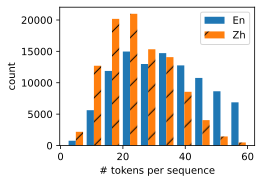

In [4]:
from d2l import torch as d2l
d2l.show_list_len_pair_hist(['En', 'Zh'], \
                            "# tokens per sequence", 
                            "count", data["trainEn"], data["trainZh"])

In [5]:
from torch.utils.data import TensorDataset, DataLoader

def load_array(data_arrays, batch_size, is_train=True):
    dataset = TensorDataset(*data_arrays)
    return DataLoader(dataset, batch_size, shuffle=is_train)

# Zh -> En
data_arrays = (arrayZh, zh_valid_len, arrayEn, en_valid_len)
train_iter = load_array(data_arrays, batch_size=2)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print(X)
    print(X_valid_len)
    print(Y)
    print(Y_valid_len)
    break

tensor([[    0,     4,   756,  5102,     9,  3020,  1259,    48,  6957,  2882,
           565,  2801,   694,     6,     3,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1],
        [   61,   109,    68,   118,     4, 12247,  2169, 12603,     5,   123,
             6,     3,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1]])
tensor([15, 12])
tensor([[  10, 1114, 2132,    5,    4,  840,   49,  177,   12,   95,   13,  630,
         2042,  633, 1957, 3532,  903,    8,    3,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,   

In [6]:
from torch import nn


class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, X):
        raise NotImplementedError
    

class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def init_state(self, enc_outputs):
        raise NotImplementedError
    
    def forward(self, X, state):
        raise NotImplementedError
    

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X):
        enc_outputs = self.encoder(enc_X)
        dec_state = self.decoder.init_state(enc_outputs)
        return self.decoder(dec_X, dec_state)
    

class Seq2SeqEncoder(Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, \
                 dropout=0) -> None:
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X):
        X = self.embedding(X) # (batch_size, num_steps) -> (batch_size, num_steps, embed_size)
        X = X.permute(1, 0, 2) # (batch_size, num_steps, embed_size) -> (num_steps, batch_size, embed_size)
        output, state = self.rnn(X)
        # output shape : (num_steps, batch_size, num_hiddens)
        # state shape : (num_layers, batch_size, num_hiddens)
        return output, state


# encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
# encoder.eval()
# X = torch.zeros((4, 7), dtype=torch.long)
# output, state = encoder(X)
# print(output.shape, state.shape)


class Seq2SeqDecoder(Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, \
                 dropout=0) -> None:
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size+num_hiddens, num_hiddens, num_layers, \
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs):
        return (enc_outputs[1], enc_outputs[1][-1])
    
    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2) # (batch_size, num_steps) -> (num_steps, batch_size, embed_size)
        context = state[-1].repeat(X.shape[0], 1, 1) # context shape : (num_steps, batch_size, num_hiddens)
        encode = state[1]
        state = state[0]
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output shape : (batch_size, num_steps, vocab_size)
        # state shape : (num_layers, batch_size, num_hiddens)
        return output, (state, encode)
    

# decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
# decoder.eval()
# state = decoder.init_state(encoder(X))
# output, state = decoder(X, state)
# print(output.shape, state.shape)

def sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, \
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X


class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    '''
    pred shape : (batch_size, num_steps, vocab_size)
    label shape : (batch_size, num_steps)
    valid_len shape : (batch_size,)
    '''
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = "none"
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label
        )
        weighted_loss = (unweighted_loss*weights).mean(dim=1)
        return weighted_loss
    

# loss = MaskedSoftmaxCELoss()
# loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))

In [7]:
embed_size, num_hiddens, num_layers, dropout = 64, 128, 2, 0.1
batch_size, zh_num_steps, en_num_steps = 64, 45, 60
lr, num_epochs, device = 1e-3, 10, d2l.try_gpu()

In [8]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device, pre_trained=None):
    net.to(device)
    if pre_trained:
        net.load_state_dict(torch.load(pre_trained, map_location=device))
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel="epoch", ylabel="loss", xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']]*Y.shape[0], \
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = net(X, dec_input)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch+1)%1 == 0:
            animator.add(epoch+1, (metric[0]/metric[1], ))
    print(f"loss {metric[0]/metric[1]:.3f} on {str(device)}")
    

data_arrays = (arrayZh, zh_valid_len, arrayEn, en_valid_len)
train_iter = load_array(data_arrays, batch_size=batch_size)

encoder = Seq2SeqEncoder(len(vocabZh), embed_size, num_hiddens, num_layers, \
                         dropout)
decoder = Seq2SeqDecoder(len(vocabEn), embed_size, num_hiddens, num_layers, \
                         dropout)
net = EncoderDecoder(encoder, decoder)
# train_seq2seq(net, train_iter, lr, num_epochs, vocabEn, device)

In [9]:
def predict_seq2seq(net, src_tokens, src_vocab, tgt_vocab, src_num_steps, \
                    tgt_num_steps, device, pre_trained=None):
    if pre_trained:
        net.load_state_dict(torch.load(pre_trained, map_location=device))
    net.eval()
    src_tokens = src_vocab[src_tokens]+[src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, src_num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(\
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X)
    dec_state = net.decoder.init_state(enc_outputs)
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device
    ), dim=0)
    output_seq = []
    for _ in range(tgt_num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq))


# weight_file = './30epochs.pth'
# metric = d2l.Accumulator(4)
# for zh, en in zip(data['devZh'], data['devEn']):
#     translation = predict_seq2seq(net, zh, vocabZh, vocabEn, zh_num_steps, \
#                                   en_num_steps, device, pre_trained=weight_file)
#     # try:
#     #     print(f'zh: {" ".join(zh)}\ntranslation: {translation}\n label: {" ".join(en)}')
#     #     print(f'bleu : {d2l.bleu(translation, " ".join(en), k=2)}')
#     # except:
#     #     pass
#     metric.add(*[d2l.bleu(translation, " ".join(en), k=i) for i in [1, 2, 4]], 1)
# print(f'BLEU1: {metric[0]/metric[3]}')
# print(f'BLEU2: {metric[1]/metric[3]}')
# print(f'BLEU4: {metric[2]/metric[3]}')

In [13]:
weight_file = './30epochs.pth'
metric = d2l.Accumulator(4)
for zh, en in zip(data['testZh'][-100:], data['testEn'][-100:]):
    translation = predict_seq2seq(net, zh, vocabZh, vocabEn, zh_num_steps, \
                                  en_num_steps, device, pre_trained=weight_file)
    print(f'zh: {" ".join(zh)}\ntranslation: {translation}\n label: {" ".join(en)}')
    print(f'bleu : {d2l.bleu(translation, " ".join(en), k=2)}')
    metric.add(*[d2l.bleu(translation, " ".join(en), k=i) for i in [1, 2, 4]], 1)

zh: 新华 网上 , 建起 了 一个 " 王伟 烈士 网上 纪念馆 " .
translation: the exhibition was the " code of video propaganda files on the internet on the internet . "
 label: a " martyr wang wei 's online memorial hall " was set up on xinhuanet . com .
bleu : 0.0
zh: 鲍彤 也 证实 赵紫阳 在 " 六四 " 期间 先后 两 辞职 , 一次 是 在 政治局 常委会 上 , 另 一 次 则是 向 政治局 常委 交上 一 封 由 他 代 写 的 辞职信 .
translation: he said that he was very responsible for the trial of the " confession - - " to the court of the first trial , and he was arrested by the head of the <unk> party .
 label: not long after , when he asked the investigation team about his summation , the team said that it had been referred to the central authorities for further instructions . bao tong confirmed that zhao ziyang submitted two resignation letters during the 4 june incident period .
bleu : 0.2020228377774691
zh: 这些 , 生动 地 体现 了 党 和 人民 对 子弟兵 生命 的 无比 珍视 , 体现 了 中华 民族 的 伟大 凝聚力 .
translation: all this shows that the party has always been struggling to revitalize the party and the peopl